In [129]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Load and clean the dataset
data = pd.read_csv('Housing.csv')

# Display dataset info
print("Dataset Info:")
print(data.info())

# DATA PREPROCESSING

# Check for duplicates
print("\nDuplicate Rows:")
duplicate_count = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

if duplicate_count > 0:
    data = data.drop_duplicates()
    print(f"Duplicates removed. Dataset now has {len(data)} rows.")

# Use SimpleImputer to impute missing values
# Impute numerical columns with the median value
numerical_cols = data.select_dtypes(include=["int64", "float64"]).columns.tolist()
numerical_imputer = SimpleImputer(strategy='median')  # or use 'mean' depending on your preference

# Impute categorical columns with the most frequent value (mode)
categorical_cols = data.select_dtypes(include=["object"]).columns.tolist()
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Apply imputation
data[numerical_cols] = numerical_imputer.fit_transform(data[numerical_cols])
data[categorical_cols] = categorical_imputer.fit_transform(data[categorical_cols])

# After imputation, check again for missing values
print("\nMissing Values after Imputation:")
missing_values_after_imputation = data.isnull().sum()
print(missing_values_after_imputation)


categorical_cols = data.select_dtypes(include=["object"]).columns.tolist()
for col in categorical_cols:
    if data[col].dtype == 'object':
        if data[col].isin(['yes', 'no']).all():
            data[col] = data[col].map({'yes': 1, 'no': 0})
        else:
            data[col] = pd.Categorical(data[col]).codes


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB
None

Duplicate Rows:
Number of duplicate rows: 0

Missing Values after Imputation:
price               0
area                0
bedrooms    


Basic Statistics:
              price          area    bedrooms   bathrooms     stories  \
count  5.450000e+02    545.000000  545.000000  545.000000  545.000000   
mean   4.766729e+06   5150.541284    2.965138    1.286239    1.805505   
std    1.870440e+06   2170.141023    0.738064    0.502470    0.867492   
min    1.750000e+06   1650.000000    1.000000    1.000000    1.000000   
25%    3.430000e+06   3600.000000    2.000000    1.000000    1.000000   
50%    4.340000e+06   4600.000000    3.000000    1.000000    2.000000   
75%    5.740000e+06   6360.000000    3.000000    2.000000    2.000000   
max    1.330000e+07  16200.000000    6.000000    4.000000    4.000000   

         mainroad   guestroom    basement  hotwaterheating  airconditioning  \
count  545.000000  545.000000  545.000000       545.000000       545.000000   
mean     0.858716    0.177982    0.350459         0.045872         0.315596   
std      0.348635    0.382849    0.477552         0.209399         0.465180   
min    

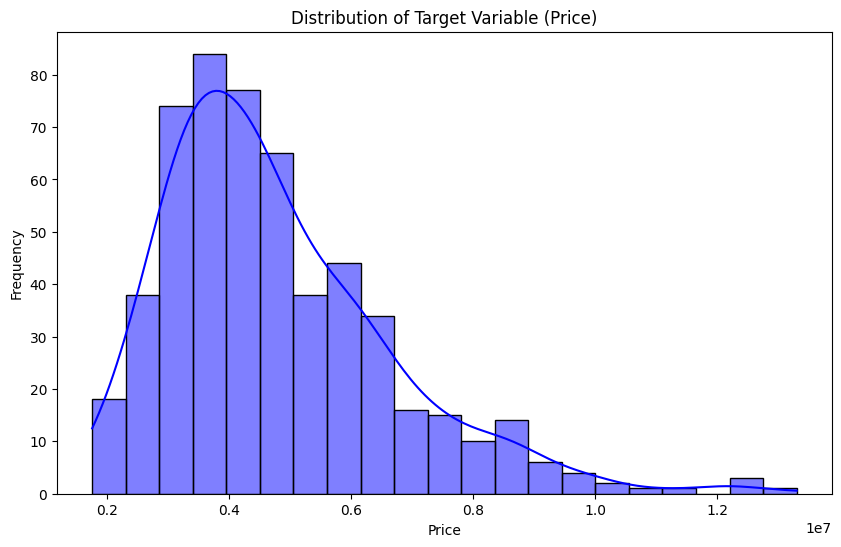

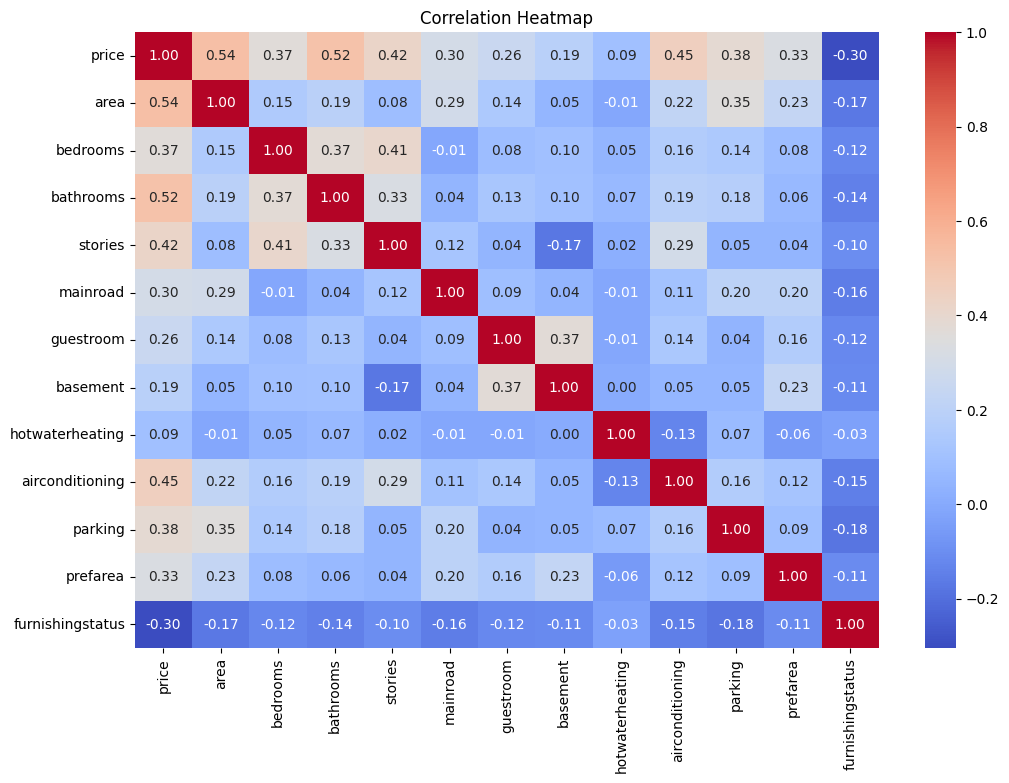

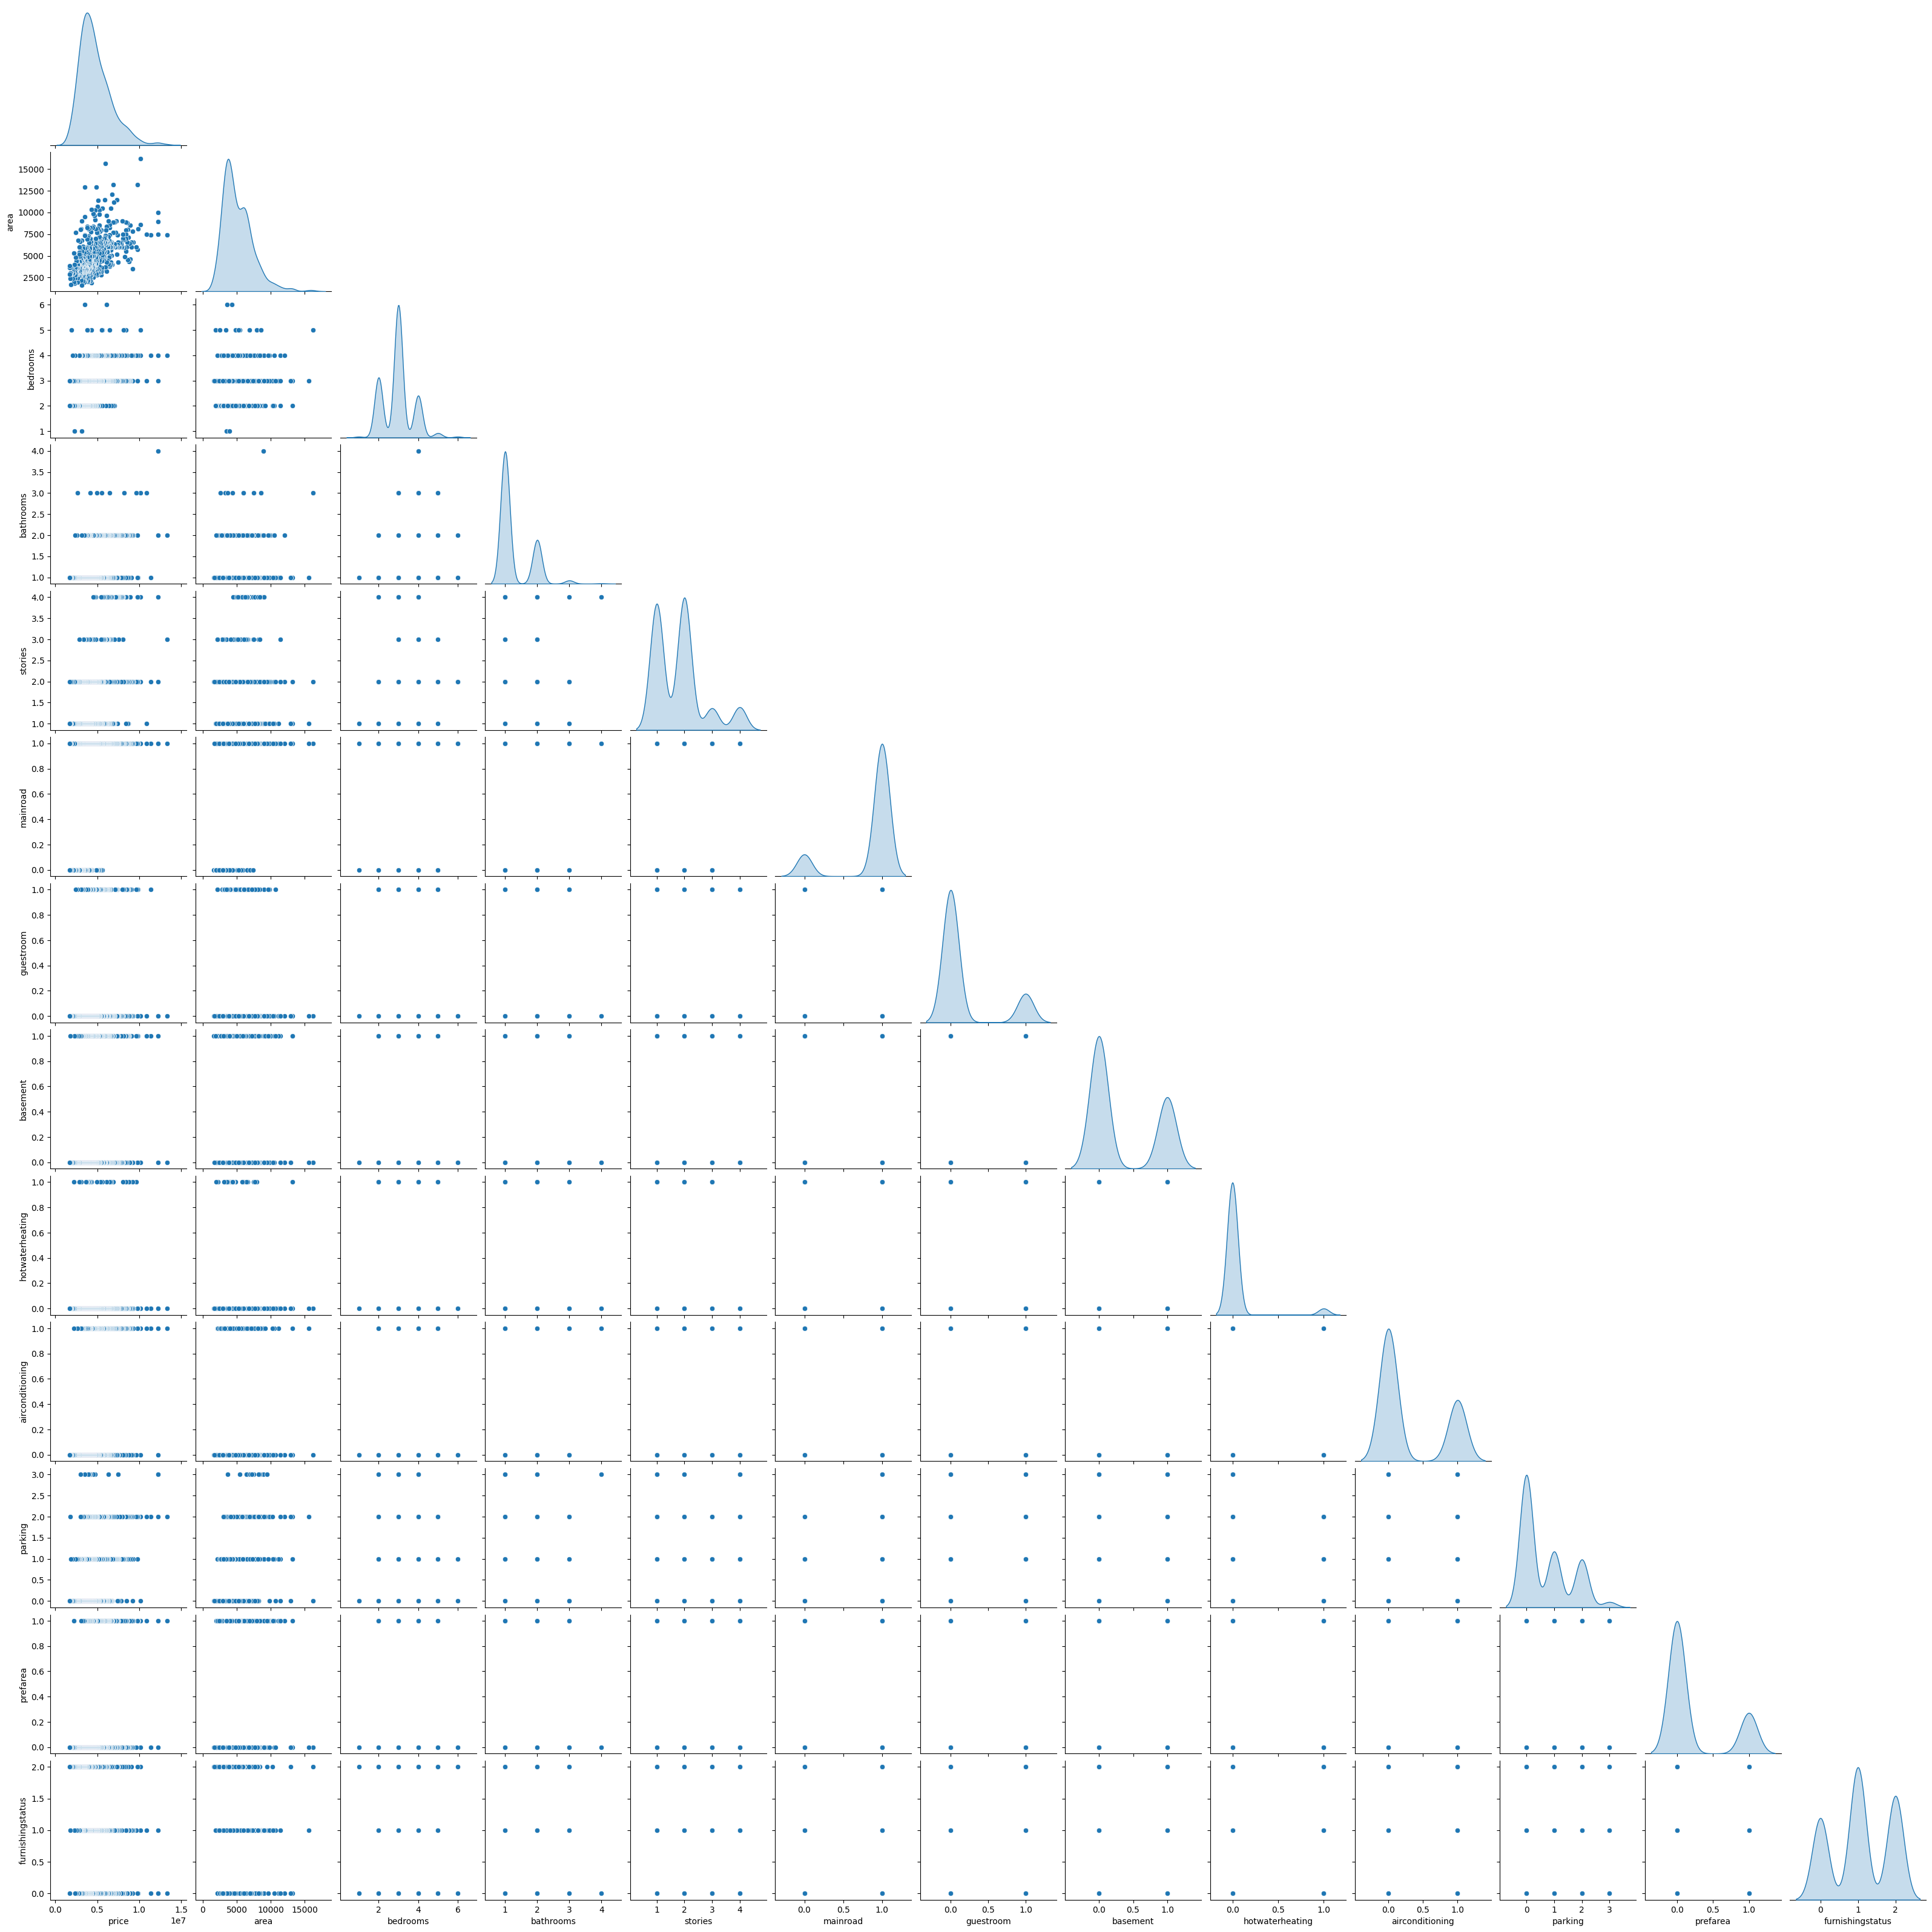

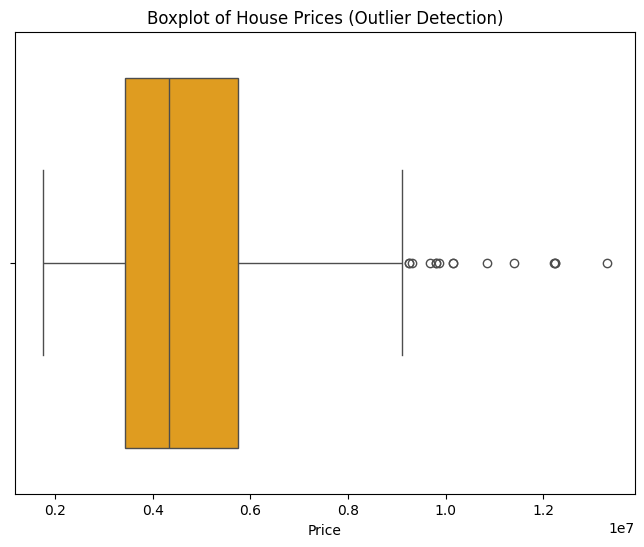

Number of outliers: 15
Dataset size after removing outliers: (530, 13)


In [130]:
# EXPLORATORY DATA ANALYSIS (EDA)
print("\nBasic Statistics:")
print(data.describe())

# Distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(data["price"], kde=True, color="blue")
plt.title("Distribution of Target Variable (Price)")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Pairplot of numerical features
sns.pairplot(data, diag_kind="kde", corner=True)
plt.show()

# Boxplot for the target variable (price) outlier
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['price'], color='orange')
plt.title("Boxplot of House Prices (Outlier Detection)")
plt.xlabel("Price")
plt.show()

# outlier removal
# Calculate IQR for 'price' column
Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

# Define upper and lower bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers in the 'price' column
outliers = data[(data['price'] < lower_bound) | (data['price'] > upper_bound)]
print(f"Number of outliers: {len(outliers)}")

data_cleaned = data[(data['price'] >= lower_bound) & (data['price'] <= upper_bound)]
print(f"Dataset size after removing outliers: {data_cleaned.shape}")

In [131]:

# SELECTING AND TRAINING VARIOUS MODELS

# Separate target and features
target_column = "price"  # Target variable
X = data_cleaned.drop(columns=[target_column])
y = data_cleaned[target_column]

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

# Preprocessing pipeline
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[('num', numerical_transformer, numerical_cols),
                  ('cat', categorical_transformer, categorical_cols)]
)

# Preprocess data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Initialize models
lr_model = LinearRegression()
dt_model = DecisionTreeRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)

# Evaluate models
def evaluate_model(model_name, model, X_test, y_test, predictions):
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    print(f"{model_name} Evaluation:")
    print(f"R-squared: {r2:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Mean Squared Error: {mse:.4f}")
    print("-" * 50)
    
def cross_validate_model(model, X_train, y_train):
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print(f"Cross-validation MSE for {model.__class__.__name__}: {-scores.mean():.4f}")

# Hyperparameter tuning for Decision Tree and Random Forest using GridSearchCV
param_grid_dt = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV for Decision Tree
grid_search_dt = GridSearchCV(dt_model, param_grid_dt, cv=5, scoring='neg_mean_squared_error')
grid_search_dt.fit(X_train_processed, y_train)
best_dt_model = grid_search_dt.best_estimator_
print(f"Best parameters for Decision Tree: {grid_search_dt.best_params_}")

# GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train_processed, y_train)
best_rf_model = grid_search_rf.best_estimator_
print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")
# Fit models
lr_model.fit(X_train_processed, y_train)
dt_model.fit(X_train_processed, y_train)
rf_model.fit(X_train_processed, y_train)

# Make predictions
lr_preds = lr_model.predict(X_test_processed)
dt_preds = dt_model.predict(X_test_processed)
rf_preds = rf_model.predict(X_test_processed)

# Evaluate all models
evaluate_model('Linear Regression', lr_model, X_test_processed, y_test, lr_preds)
evaluate_model('Decision Tree', dt_model, X_test_processed, y_test, dt_preds)
evaluate_model('Random Forest', rf_model, X_test_processed, y_test, rf_preds)

# Cross-validate models
cross_validate_model(lr_model, X_train_processed, y_train)
cross_validate_model(best_dt_model, X_train_processed, y_train)
cross_validate_model(best_rf_model, X_train_processed, y_train)



Best parameters for Decision Tree: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Linear Regression Evaluation:
R-squared: 0.6489
Mean Absolute Error: 818791.1209
Mean Squared Error: 1215825380211.7498
--------------------------------------------------
Decision Tree Evaluation:
R-squared: 0.4495
Mean Absolute Error: 1076387.3585
Mean Squared Error: 1906306775007.5471
--------------------------------------------------
Random Forest Evaluation:
R-squared: 0.6065
Mean Absolute Error: 910605.2984
Mean Squared Error: 1362403108336.6069
--------------------------------------------------
Cross-validation MSE for LinearRegression: 856980823028.1340
Cross-validation MSE for DecisionTreeRegressor: 1165605677921.3306
Cross-validation MSE for RandomForestRegressor: 937731939248.4008


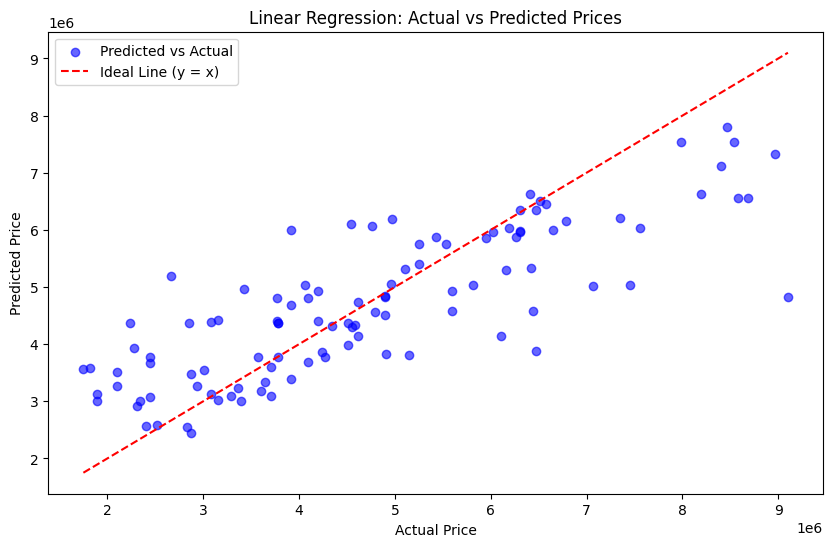

In [128]:

# EVALUATE PERFORMANCE ON TEST SET OF DATA 
lr_preds = lr_model.predict(X_test_processed)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lr_preds, color='blue', alpha=0.6, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Line (y = x)')
plt.title("Linear Regression: Actual vs Predicted Prices")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.legend()
plt.show()


Missing Values:
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

Duplicate Rows:
Number of duplicate rows: 0

Missing Values after Imputation:
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64
[5273279.66844293 6980109.31856151 7057616.2113268  6590405.87286791
 8298650.94920272 8403686.33424691 7326228.64857729 8365184.1687236
 9200845.74377898 5777969.51534241 8426294.69595949 5390152.08432043
 8159651.62159657 8968703.5746419  9311920.03996302 7222777.71276811
 7111935.74013874 7719035.20391779 6884948.22241173 7966373.86576834]


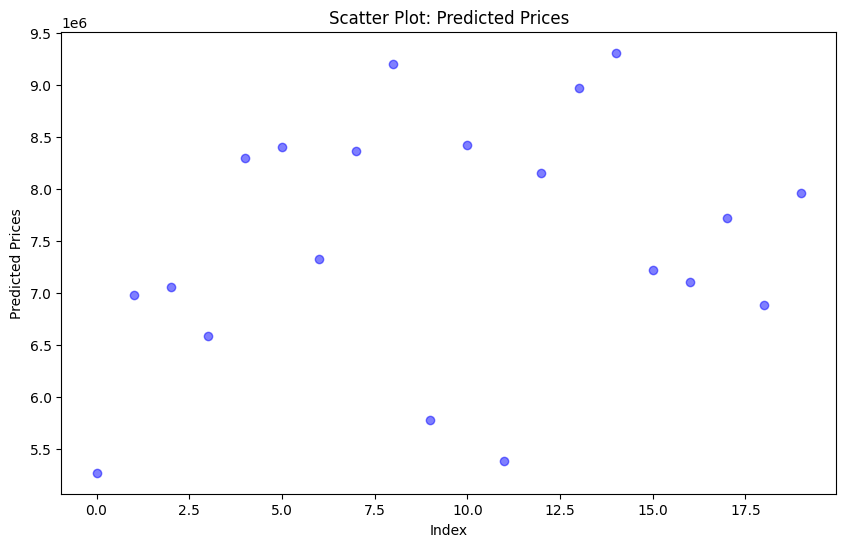

       price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0   11251741  5302         2          2        1       no       yes      yes   
1   14421155  8441         3          2        2       no       yes      yes   
2   14683812  5076         4          3        1       no       yes      yes   
3   13202914  9583         3          1        2       no        no      yes   
4   13241191  8973         1          2        1      yes       yes      yes   
5   10772491  7530         4          3        1      yes       yes      yes   
6   12889458  7457         1          3        2      yes       yes       no   
7   10341698  7831         5          2        2      yes       yes      yes   
8   11700522  9289         3          4        3      yes       yes      yes   
9   11671084  9117         4          2        2      yes        no       no   
10  14627517  9904         1          4        2      yes       yes      yes   
11  13066375  5727         2          1 

In [132]:
#EVALUATING PERFORMANCE ON NEW SET OF DATA (kindly note that )

# Load the new data from CSV
new_data = pd.read_csv('Generated_Housing.csv')

# Assuming you have already defined your preprocessing pipeline and trained model (lr_model)
# Apply the same preprocessing to the new data
def preprocess_new_data(new_data, preprocessor):
    target_column = "price"  # Target variable
    y = new_data[target_column]
    new_data = new_data.drop(columns=[target_column])
    
    print("\nMissing Values:")
    missing_values = new_data.isnull().sum()
    print(missing_values)

    # Check for duplicates
    print("\nDuplicate Rows:")
    duplicate_count = new_data.duplicated().sum()
    print(f"Number of duplicate rows: {duplicate_count}")

    if duplicate_count > 0:
        new_data = new_data.drop_duplicates()
        print(f"Duplicates removed. Dataset now has {len(new_data)} rows.")
    
    # Handle missing values with SimpleImputer
    numerical_cols = new_data.select_dtypes(include=["int64", "float64"]).columns.tolist()
    numerical_imputer = SimpleImputer(strategy='median')
    categorical_cols = new_data.select_dtypes(include=["object"]).columns.tolist()
    categorical_imputer = SimpleImputer(strategy='most_frequent')

    new_data[numerical_cols] = numerical_imputer.fit_transform(new_data[numerical_cols])
    new_data[categorical_cols] = categorical_imputer.fit_transform(new_data[categorical_cols])

    # After imputation, check again for missing values
    print("\nMissing Values after Imputation:")
    missing_values_after_imputation = new_data.isnull().sum()
    print(missing_values_after_imputation)

    # Apply categorical encoding
    for col in categorical_cols:
        if new_data[col].dtype == 'object':
            if new_data[col].isin(['yes', 'no']).all():
                new_data[col] = new_data[col].map({'yes': 1, 'no': 0})
            else:
                new_data[col] = pd.Categorical(new_data[col]).codes
    
    # Apply preprocessing pipeline
    new_data_processed = preprocessor.transform(new_data)
    
    return new_data_processed, y

new_data_processed, y = preprocess_new_data(new_data, preprocessor)

# Make predictions using the trained model
predictions = lr_model.predict(new_data_processed)

# Print the predictions
print(predictions)

formatted_predictions = [f"${price:,.2f}" for price in predictions]

# Add predictions to the original DataFrame as a new column
new_data['Predicted Price'] = formatted_predictions

#Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(predictions)), predictions, color='blue', alpha=0.5)
plt.title("Scatter Plot: Predicted Prices")
plt.xlabel("Index")
plt.ylabel("Predicted Prices")
plt.show()

# Display the updated DataFrame with predictions
print(new_data)
